In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width: 95% !important;}</style>"))

import gc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import pandas as pd

import networkx as nx

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy import linalg

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(precision=4, suppress=True)

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,5)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 300})

## 1. Preprocessing data

In [2]:
%%time
import pickle

tournaments = pickle.load(open("chgk/tournaments.pkl", "rb"))
results = pickle.load(open("chgk/results.pkl", "rb"))
players = pickle.load(open("chgk/players.pkl", "rb"))

CPU times: user 8.31 s, sys: 1.03 s, total: 9.34 s
Wall time: 11.7 s


In [3]:
train_tournaments = {}
test_tournaments = {}
for idx, tournament_info in tournaments.items():
    try:
        if results[idx][0]["mask"] is not None and len(results[idx][0]["teamMembers"]) > 0:
            if tournament_info["dateStart"][:4] == "2019":
                train_tournaments[idx] = tournament_info
            elif tournament_info["dateStart"][:4] == "2020":
                test_tournaments[idx] = tournament_info
    except IndexError as e:
        continue
    except KeyError as e:
        continue

In [4]:
len(train_tournaments)

674

In [5]:
len(test_tournaments)

173

## 2. Baseline model

Будем заменять "X" и "?" на 0, как будто бы команда неправильно ответила на вопрос для того, чтобы длины масок были одинаковыми.

In [6]:
def len_without_incorr_symb(s):
    l = 0
    for c in s:
        if c not in ["X", "?"]:
            l += 1
    return l

def get_amount_of_correct_answers_from_str(s):
    cnt = 0
    for c in s:
        if c not in ["X", "?"]:
            cnt += int(c)
    return cnt

from collections import defaultdict
def get_correct_answers_ratio(df):
    players_amount_of_correct_answers = defaultdict(int)
    players_amount_of_answers = defaultdict(int)
    for tournament_idx in df:
        for info in results[tournament_idx]:
            if info["mask"] == None:
                continue
            for players_ in info["teamMembers"]:
                players_amount_of_correct_answers[players_["player"]["id"]] += get_amount_of_correct_answers_from_str(info["mask"])
                players_amount_of_answers[players_["player"]["id"]] += len(info["mask"])
    assert len(players_amount_of_correct_answers) == len(players_amount_of_answers)
    ratio = {player_id: players_amount_of_correct_answers[player_id] / players_amount_of_answers[player_id] for player_id in players_amount_of_correct_answers}
    return ratio

Посчитаем долю правильных ответов игрока.

In [7]:
%%time
train_ratio_of_correct_answers = get_correct_answers_ratio(train_tournaments)

CPU times: user 3.26 s, sys: 1.22 ms, total: 3.27 s
Wall time: 3.27 s


Посчитаем сложность вопроса как: $1 - \frac{\text{число правильно ответивших команд}}{\text{общее число команд}}$

In [8]:
def from_str_mask_to_arr(s):
    cnt = []
    for c in s:
        if c not in ["X", "?"]:
            cnt.append(int(c))
        else:
            cnt.append(0)
    return cnt

def get_question_complexity(df):
    question_complexity_by_tournament = defaultdict(int)
    for tournament_idx in df:
        tmp_masks = []
        try:
            for info in results[tournament_idx]:
                tmp_masks.append(from_str_mask_to_arr(info["mask"]))
            flg = all(list(map(lambda x: len(x) == len(tmp_masks[0]), tmp_masks)))
            if not flg:
                continue
            tmp_masks_sum = np.array(tmp_masks).reshape(len(results[tournament_idx]), -1).sum(axis=0)
            quest_complexity = list(map(lambda x: 1 - x / len(results[tournament_idx]), tmp_masks_sum))
            question_complexity_by_tournament[tournament_idx] = quest_complexity
        except TypeError as e:
            continue
    return question_complexity_by_tournament

In [9]:
%%time
train_quest_compl = get_question_complexity(train_tournaments)

CPU times: user 894 ms, sys: 0 ns, total: 894 ms
Wall time: 913 ms


Создадим датасет для обучения baseline log reg, который будет состоять из следующих колонок:
* player_id
* tourn_question_id
* доля правильных ответов игрока за все время
* сложность вопроса
* позиция команды
* количество команд
* ответ на вопрос

In [10]:
%%time
part_2_full_players = []
for tourn_idx, question_complexities in tqdm(train_quest_compl.items()):
    cmd_cnt = len(results[tourn_idx])
    for info in results[tourn_idx]:
        mask = from_str_mask_to_arr(info["mask"])
        position = info["position"] / cmd_cnt
        for players_ in info["teamMembers"]:
            for idx, m_compl in enumerate(zip(mask, question_complexities)):
                part_2_full_players.append([players_["player"]["id"],
                                            str(tourn_idx) + "_" + str(idx),
                                            train_ratio_of_correct_answers[players_["player"]["id"]],
                                            m_compl[1],
                                            position,
                                            cmd_cnt,
                                            m_compl[0]])

  0%|          | 0/660 [00:00<?, ?it/s]

CPU times: user 30.4 s, sys: 593 ms, total: 31 s
Wall time: 31 s


Тут была попытка добавить графовые фичи, но она не дала дополнительного качества.

In [11]:
# %%time
# hits_nodes = []
# PLAYER_ID_ADD = 1000000
# for tournament_idx in train_tournaments:
#     for info in results[tournament_idx]:
#         for players_ in info["teamMembers"]:
#             hits_nodes.append((players_["player"]["id"] + PLAYER_ID_ADD, tournament_idx))
#             hits_nodes.append((tournament_idx, players_["player"]["id"] + PLAYER_ID_ADD))

In [12]:
# %%time
# players_tournaments = nx.DiGraph()
# players_tournaments.add_edges_from(hits_nodes)

In [13]:
# %%time
# hubs, authorities = nx.hits(players_tournaments)

In [14]:
# degree_centrality = nx.degree_centrality(G=players_tournaments)

In [15]:
part_2_full_players_df = pd.DataFrame(part_2_full_players, columns=["player_id", "tourn_question_id","corr_answ_ratio", "quest_complexity", "cmd_pos", "cmd_cnt_in_tournament", "player_answer"]).astype({"player_id": "int",
                                                                                                                                                     "tourn_question_id": "object",
                                                                                                                                                     "corr_answ_ratio": "float", 
                                                                                                                                                     "quest_complexity": "float", 
                                                                                                                                                     "player_answer": "int",
                                                                                                                                                     "cmd_pos": "float",
                                                                                                                                                     "cmd_cnt_in_tournament": "int"})

In [16]:
def get_feature_for_player(feature_dict, player_id):
    return feature_dict[player_id + PLAYER_ID_ADD]

In [17]:
# part_2_full_players_df["degree_centrality"] = part_2_full_players_df["player_id"].apply(lambda x: get_feature_for_player(degree_centrality, x))
# part_2_full_players_df["hubs"] = part_2_full_players_df["player_id"].apply(lambda x: get_feature_for_player(hubs, x))
# part_2_full_players_df["authorities"] = part_2_full_players_df["player_id"].apply(lambda x: get_feature_for_player(authorities, x))

In [18]:
# part_2_full_players_df = part_2_full_players_df.drop_duplicates(ignore_index=True)

In [19]:
part_2_full_players_df["cmd_cnt_in_tournament"] = part_2_full_players_df["cmd_cnt_in_tournament"] / part_2_full_players_df["cmd_cnt_in_tournament"].max()

In [20]:
%%time
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(part_2_full_players_df.loc[:, ~part_2_full_players_df.columns.isin(["player_answer", "player_id", "tourn_question_id"])], part_2_full_players_df.loc[:, "player_answer"])

CPU times: user 23.2 s, sys: 18.7 s, total: 41.9 s
Wall time: 12.2 s


LogisticRegression()

In [21]:
log_reg.score(part_2_full_players_df.loc[:, ~part_2_full_players_df.columns.isin(["player_answer", "player_id", "tourn_question_id"])], part_2_full_players_df.loc[:, "player_answer"])

0.7873633710734862

In [22]:
log_reg_preds_by_player = log_reg.predict_proba(part_2_full_players_df.loc[:, ~part_2_full_players_df.columns.isin(["player_answer", "player_id", "tourn_question_id"])])[:, 1]

In [23]:
log_reg_preds_by_player_id = part_2_full_players_df.loc[:, ["player_id"]]
log_reg_preds_by_player_id["proba"] = log_reg_preds_by_player

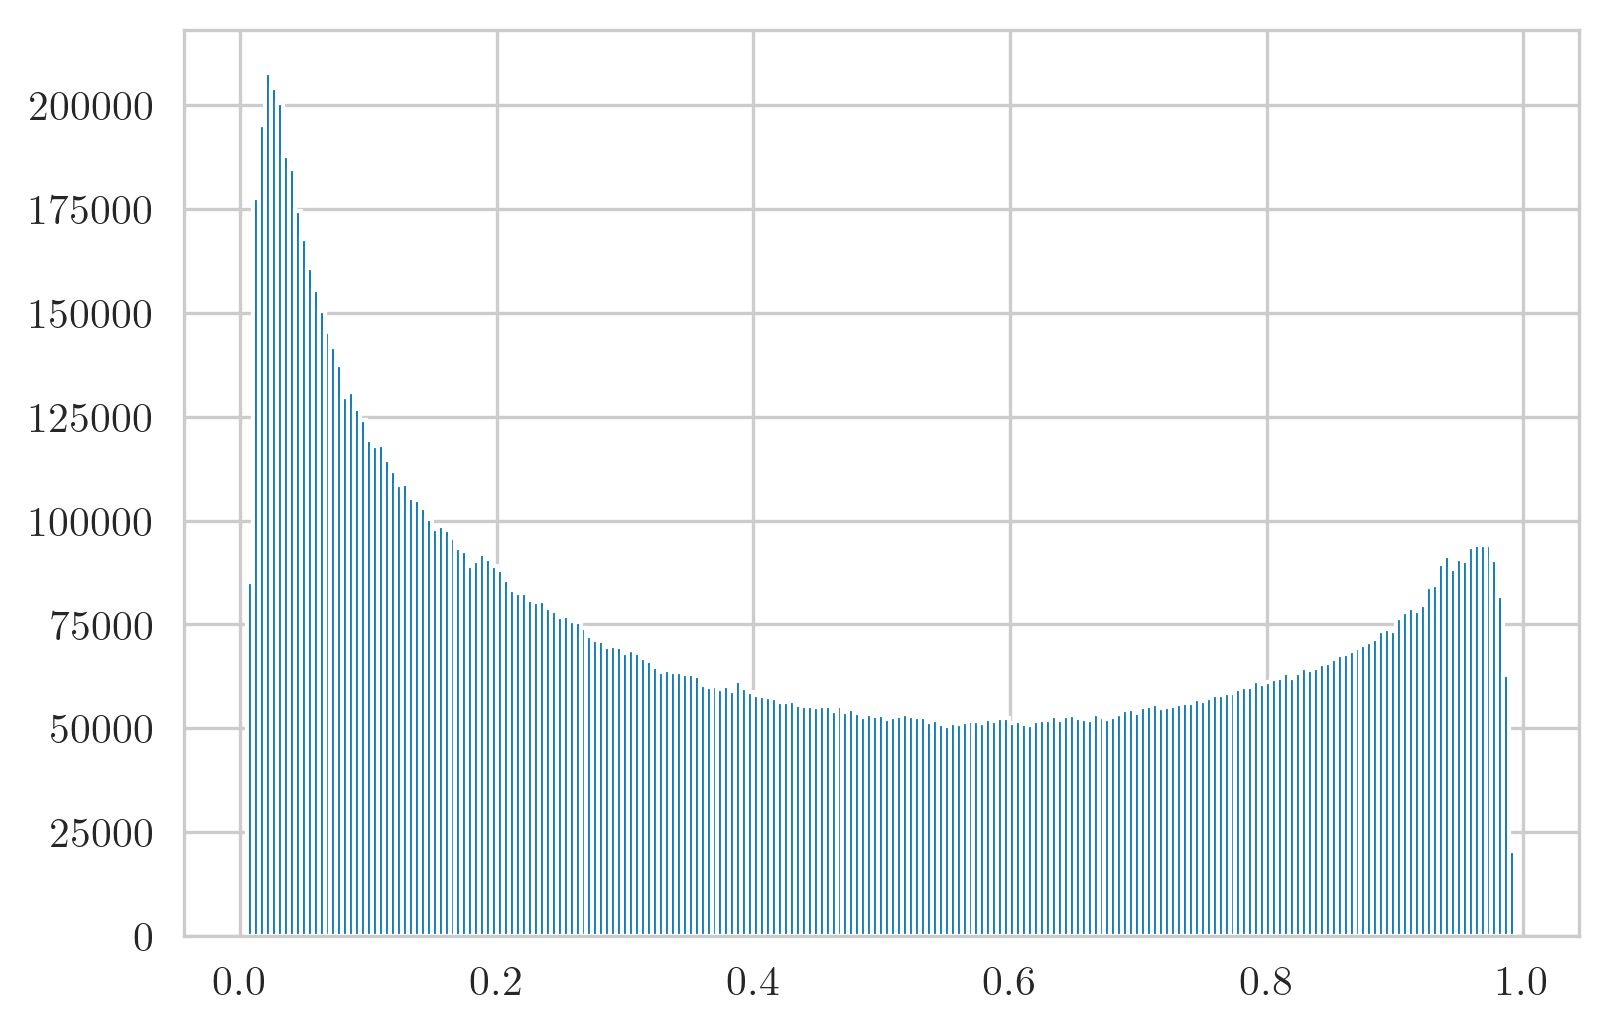

In [24]:
plt.hist(log_reg_preds_by_player, bins="auto")
plt.show()

## 3. From player power to team power

Можно усреднить силу игроков в каждой команде и по полученной величине ранжировать команды из тестового набора.

In [25]:
log_reg_preds_by_player_id_grpby = log_reg_preds_by_player_id.groupby(["player_id"])["proba"].mean().to_dict()

In [26]:
%%time
from scipy.stats import kendalltau, spearmanr
spearman = []
kendall = []
for tournament_idx in test_tournaments:
    cmds_power = []
    for info in results[tournament_idx]:
        try:
            cmds_power.append(np.mean(list(map(lambda x: log_reg_preds_by_player_id_grpby[x["player"]["id"]], info["teamMembers"]))))
        except KeyError:
            continue
    temp = np.array(cmds_power).argsort()[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(1, len(cmds_power) + 1)
    sp_coef = spearmanr(range(1, len(cmds_power) + 1), ranks)[0]
    kd_coef = kendalltau(range(1, len(cmds_power) + 1), ranks)[0]
    if not np.isnan(sp_coef):
        spearman.append(sp_coef)
    if not np.isnan(kd_coef):
        kendall.append(kd_coef)

CPU times: user 305 ms, sys: 0 ns, total: 305 ms
Wall time: 375 ms


In [27]:
np.mean(spearman)

0.6897985443132023

In [28]:
np.mean(kendall)

0.5255529925418483

## 4. EM

Пусть скрытая переменная $Z_{nk}^{t}$ - индикатор, который обозначает ответ $k$-го игрока из команды $t$ на $n$-ый вопрос, веса игроков в команде $\pi_{k}^{t}$ - вес $k$-го игрока из команды $t$, $\theta_{k}^{t}$ - сила (вероятность правильно ответить на вопрос) $k$-го игрока из команды $t$. Везде ниже опустим верхний индекс $t$, потому что мы будем рассматривать шаг EM-алгоритма в рамках одной команды, а после будем усреднять оценки силы игрока по всем командам, в которых он успел поиграть.

Считаем, что данные порождены независимо, и дифференцируя функцию $Q$ по $\theta_{k}$, получаем следующие формулы:
1. E-шаг: 
    $$p(Z_{nk}|X, \theta) = \frac{\pi_{k}p(x_{n}|\theta_{k})}{\sum\limits_{l}\pi_{l}p(x_{n}|\theta_{l})}$$
    $$p(x_{n}|\theta_{k}) = \theta_{k}^{x_{n}}(1 - \theta_{k})^{1 - x_{n}} (= \theta_{k}x_{n} + (1 - \theta_{k})(1 - x_{n})) \sim Be(x_{n}|\theta_{k})$$ 
2. M-шаг:
    $$\theta_{k} = \frac{\sum\limits_{n}\mathbb{E}[Z_{nk}]x_{n}}{\sum\limits_{n}\mathbb{E}[Z_{nk}]}$$
    $$\pi_{k} = \frac{1}{n}\sum\limits_{n}\mathbb{E}[Z_{nk}]$$
3. Агрегация: поскольку один и тот же игрок мог в разные моменты времени играть за разные команды, то после M-шага необходимо усреднить его "силы", с которыми он играл за разные команды.

Для ускорения сходимости не будем использовать равномерное распределение, а проинициализируем силы игроков долей правильных ответов его команды.
Вклад каждого игрока оставим равномерным.

In [29]:
del part_2_full_players_df
gc.collect()

15475

In [32]:
# Data schema
# tourn_team_id, tourn_question_id, player_id, team_answer, PI_weights, THETA_player_power
full_players_list = []
for tourn_idx in tqdm(train_quest_compl.keys()):
    for info in results[tourn_idx]:
        tmp_comd = []
        mask = from_str_mask_to_arr(info["mask"])
        players_cnt = len(info["teamMembers"])
        pi_weights = np.ones(players_cnt) / players_cnt
        theta_player_power = np.ones(players_cnt) * (sum(mask) / len(mask))
        for idx, players_ in enumerate(info["teamMembers"]):
            for mask_idx, m in enumerate(mask):
                full_players_list.append([str(tourn_idx) + "_" + str(info["team"]["id"]),
                                          str(tourn_idx) + "_" + str(mask_idx),
                                          str(players_["player"]["id"]),
                                          m,
                                          pi_weights[idx],
                                          theta_player_power[idx]])

  0%|          | 0/660 [00:00<?, ?it/s]

In [112]:
full_players_df = pd.DataFrame(data=full_players_list, columns=["tourn_team_id",
                                                                "tourn_question_id",
                                                                "player_id", 
                                                                "team_answer", 
                                                                "PI_weights", 
                                                                "THETA_player_power"])

In [113]:
def get_z_hidden(pi_vec, theta_vec, x_vec, players_cnt, questions_cnt):
    prob_vec = np.multiply(theta_vec, x_vec) + np.multiply((np.ones_like(theta_vec, dtype=float) - theta_vec), 
                                                           (np.ones_like(x_vec, dtype=float) - x_vec))
    numerators = np.multiply(prob_vec, pi_vec).reshape(questions_cnt, players_cnt)
    denominators = numerators.sum(axis=1).reshape(-1, 1)
    return numerators / denominators

def expectation(df, players_cnt, questions_cnt):
    z_hidden = get_z_hidden(
        df["PI_weights"].values, 
        df["THETA_player_power"].values,
        df["team_answer"].values,
        players_cnt,
        questions_cnt
    )
    return z_hidden

def maximization(z_matrix, df, questions_cnt, players_cnt):
    z_sum = z_matrix.sum(axis=0)
    new_pi_vec = np.tile((z_sum / z_matrix.shape[0]).reshape(-1), questions_cnt)
    new_theta_vec = np.tile((df["team_answer"].values[:questions_cnt].reshape(1, -1) @ z_matrix) / (z_sum.reshape(-1, 1)).reshape(-1), questions_cnt).reshape(-1)
    return new_pi_vec, new_theta_vec

def em_iter(df):
    players_cnt = len(pd.unique(df["player_id"]))
    questions_cnt = len(pd.unique(df["tourn_question_id"]))
    z_matrix = expectation(df, players_cnt, questions_cnt)
    new_pi_vec, new_theta_vec = maximization(z_matrix, df, questions_cnt, players_cnt)
    df["PI_weights"] = new_pi_vec
    df["THETA_player_power"] = new_theta_vec
    return df

In [114]:
n_iterations = 5
for iter in tqdm(range(n_iterations)):
    full_players_df = full_players_df.groupby(["tourn_team_id"]).apply(em_iter)
    print(f"After EM iter number: {iter + 1}")
    player_power_agg = dict(full_players_df.groupby(["player_id"])["THETA_player_power"].mean())
    full_players_df["THETA_player_power"] = full_players_df["player_id"].apply(lambda x: player_power_agg[x])

  0%|          | 0/5 [00:00<?, ?it/s]

After EM iter number: 1
After EM iter number: 2
After EM iter number: 3
After EM iter number: 4
After EM iter number: 5


In [115]:
em_player_id_power = dict(full_players_df.loc[:, ["player_id", "THETA_player_power"]].drop_duplicates().values)

In [116]:
spearman = []
kendall = []
for tournament_idx in test_tournaments:
    cmds_power = []
    for info in results[tournament_idx]:
        try:
            cmds_power.append(np.mean(list(map(lambda x: em_player_id_power[str(x["player"]["id"])], info["teamMembers"]))))
        except KeyError:
            continue
    temp = np.array(cmds_power).argsort()[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(1, len(cmds_power) + 1)
    sp_coef = spearmanr(range(1, len(cmds_power) + 1), ranks)[0]
    kd_coef = kendalltau(range(1, len(cmds_power) + 1), ranks)[0]
    if not np.isnan(sp_coef):
        spearman.append(sp_coef)
    if not np.isnan(kd_coef):
        kendall.append(kd_coef)

In [117]:
np.mean(spearman)

0.6856946594561684

In [118]:
np.mean(kendall)

0.5233385065629279

## 5. Tournament rating by question complexity

Поскольку при построении как baseline-модели, так и EM-модели, мы учитывали сложность вопросов, то полученные скоры можно использовать для того, чтобы оценить сложность вопросов. Т.е. можно сделать усреднение по id вопроса, а потом усреднение по всем вопросам внутри одного турнира и получить сложность турнира от 0 до 1.

In [138]:
em_quest_complexity = pd.DataFrame(full_players_df.groupby(["tourn_question_id"])["THETA_player_power"].mean()).reset_index()
em_quest_complexity["tourn_id"] = em_quest_complexity["tourn_question_id"].apply(lambda x: x.split("_")[0])
em_tourn_complexity = pd.DataFrame(em_quest_complexity.groupby(["tourn_id"])["THETA_player_power"].mean())

In [140]:
em_tourn_complexity.sort_values(by="THETA_player_power", ascending=False)

,THETA_player_power
tourn_id,
5948,0.654879
5941,0.654604
5945,0.652141
5938,0.615841
5949,0.570755
...,...
6120,0.224109
5426,0.223045
5599,0.200554


In [147]:
# первый турнир в рейтинге
train_tournaments[5948]

{'id': 5948,
 'name': 'Чемпионат Мира. Финал. Группа А',
 'dateStart': '2019-09-08T15:30:00+03:00',
 'dateEnd': '2019-09-08T17:30:00+03:00',
 'type': {'id': 2, 'name': 'Обычный'},
 'season': '/seasons/53',
 'orgcommittee': [{'id': 27247,
   'name': 'Александр',
   'patronymic': 'Аврамович',
   'surname': 'Рубин'},
  {'id': 46968,
   'name': 'Александр',
   'patronymic': 'Давидович',
   'surname': 'Двоскин'},
  {'id': 25882,
   'name': 'Максим',
   'patronymic': 'Оскарович',
   'surname': 'Поташев'},
  {'id': 144,
   'name': 'Сергей',
   'patronymic': 'Леонидович',
   'surname': 'Абрамов'},
  {'id': 11084,
   'name': 'Павел',
   'patronymic': 'Олегович',
   'surname': 'Забавский'},
  {'id': 37142,
   'name': 'Азизбек',
   'patronymic': 'Эльбек-угли',
   'surname': 'Юсуфов'},
  {'id': 31038,
   'name': 'Владимир',
   'patronymic': 'Владимирович',
   'surname': 'Сушков'}],
 'synchData': None,
 'questionQty': {'1': 15, '2': 15}}

In [148]:
# последний турнир в рейтинге
train_tournaments[5717]

{'id': 5717,
 'name': 'Чемпионат Таджикистана',
 'dateStart': '2019-06-23T14:00:00+03:00',
 'dateEnd': '2019-06-23T18:00:00+03:00',
 'type': {'id': 2, 'name': 'Обычный'},
 'season': '/seasons/52',
 'orgcommittee': [{'id': 37142,
   'name': 'Азизбек',
   'patronymic': 'Эльбек-угли',
   'surname': 'Юсуфов'},
  {'id': 98217,
   'name': 'Манучехр',
   'patronymic': 'Абдумаджидович',
   'surname': 'Салохудинов'}],
 'synchData': None,
 'questionQty': {'1': 15, '2': 15, '3': 15}}

Получается, что есть логика ранжирования.